In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

import random as rd

SEED = 2025
rd.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

basepath = os.path.join(path, "kaggle_3m")
patients = [p for p in os.listdir(basepath) if os.path.isdir(os.path.join(basepath, p))]

TOTAL_PATIENTS = len(patients)

In [ ]:
from sklearn.model_selection import train_test_split

#SPLIT 60-20-20

train_folder, remaining = train_test_split(patients, train_size=0.6, random_state=SEED)

val_folder, test_folder = train_test_split(remaining, train_size=0.5, random_state=SEED)

# Verify the count
print(f"Train Patients: {len(train_folder)} ({len(train_folder)/TOTAL_PATIENTS:.1%})")
print(f"Validation Patients: {len(val_folder)} ({len(val_folder)/TOTAL_PATIENTS:.1%})")
print(f"Test Patients: {len(test_folder)} ({len(test_folder)/TOTAL_PATIENTS:.1%})")

Train Patients: 66 (60.0%)
Validation Patients: 22 (20.0%)
Test Patients: 22 (20.0%)


In [ ]:
import shutil

dataset_dir = "/content/dataset"
os.makedirs(dataset_dir, exist_ok=True)

# --- Setup Output Directories ---
splits = {
    'train': train_folder,
    'val': val_folder,
    'test': test_folder
}

for split_name in splits.keys():
    os.makedirs(os.path.join(dataset_dir, split_name), exist_ok=True)

# --- Move/Copy Folders ---
for split_name, patient_list in splits.items():
    dest_dir = os.path.join(dataset_dir, split_name)

    for patient_folder_name in patient_list:
        src_path = os.path.join(basepath, patient_folder_name)
        dest_path = os.path.join(dest_dir, patient_folder_name)

        # Use shutil.copytree for copying the entire directory, including all MRI slices.
        # Use shutil.move if you prefer to physically move the folder instead of copying.
        shutil.copytree(src_path, dest_path)

print("\nPatient-Level Splitting Complete!")


Patient-Level Splitting Complete!


In [ ]:
#Split the folders in img_folders and mask_folders (labels)

for split_name, patient_list in splits.items():
  temp_base_path = os.path.join(dataset_dir, split_name)

  for patient in patient_list:
    img_dest_dir = os.path.join(temp_base_path, patient, "images")
    mask_dest_dir = os.path.join(temp_base_path, patient, "mask")
    os.makedirs(img_dest_dir, exist_ok=True)
    os.makedirs(mask_dest_dir, exist_ok=True)

    files = [f for f in os.listdir(os.path.join(temp_base_path, patient)) if not os.path.isdir(os.path.join(temp_base_path, patient, f))]

    for f in files:
      src_path = os.path.join(temp_base_path, patient, f)
      if "_mask" in f:
        dst_path = os.path.join(mask_dest_dir, f)
      else:
        dst_path = os.path.join(img_dest_dir, f)

      shutil.copy2(src_path, dst_path)

print("✅ Files successfully sorted into 'images/' and 'masks/' folders.")

✅ Files successfully sorted into 'images/' and 'masks/' folders.


In [ ]:
import re

def extract_slice_id(filename):
    name = os.path.splitext(filename)[0]      # remove .tif
    if name.endswith("_mask"):
        name = name[:-5]                      # remove _mask
    m = re.search(r"(\d+)$", name)            # trailing digits
    return int(m.group(1)) if m else None

## Data Augmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. Define the augmentation pipeline
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        rotate=(-15, 15),
        scale=(0.9, 1.1),
        shear=(-10, 10),
        p=0.7,
        interpolation=1,      # 1 = cv2.INTER_LINEAR (for image)
        mask_interpolation=0  # 0 = cv2.INTER_NEAREST (for mask)
    ),
    A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),

    # Pixel-level transforms are applied ONLY to the image by default
    #A.ColorJitter(brightness=0.3, contrast=0.3, p=0.5),
    #A.GaussianBlur(blur_limit=(3, 7), p=0.3),

    ToTensorV2() # Converts numpy image/mask to PyTorch tensors
])

/tmp/ipython-input-1676225931.py:15: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),


In [ ]:
class MRISegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path to train/val/test directory containing patient folders
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Loop through each patient folder
        for patient_name in sorted(os.listdir(root_dir)):
            patient_path = os.path.join(root_dir, patient_name)
            images_dir = os.path.join(patient_path, "images")
            masks_dir  = os.path.join(patient_path, "mask")

            if not os.path.isdir(images_dir) or not os.path.isdir(masks_dir):
              print(f"WARNING: {images_dir} or {masks_dir} is not a folder")
              continue  # skip malformed folders

            # sort both lists to maintain correspondence
            image_files = os.listdir(images_dir)
            mask_files = os.listdir(masks_dir)

            image_files.sort(key=lambda f: extract_slice_id(f))
            mask_files.sort(key=lambda f: extract_slice_id(f))

            # Ensure equal number of slices
            assert len(image_files) == len(mask_files), f"Mismatch in {patient_name}"

            # Pair each image with its matching mask
            for img_name, mask_name in zip(image_files, mask_files):
                # Optional: verify name correspondence (e.g. same slice number)
                if os.path.splitext(img_name)[0] not in mask_name:
                    print(f"Warning: potential mismatch {img_name} <-> {mask_name}")

                img_path = os.path.join(images_dir, img_name)
                mask_path = os.path.join(masks_dir, mask_name)
                self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]

        # Load
        image = np.array(Image.open(image_path), dtype=np.float32)
        mask  = np.array(Image.open(mask_path), dtype=np.float32)

        # Normalize per image
        image = (image - image.min(axis=(0,1), keepdims=True)) / (image.max(axis=(0,1), keepdims=True) - image.min(axis=(0,1), keepdims=True) + 1e-8)

        #Binarize the mask
        mask = (mask > 0.5).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  #(C, H, W) tensor
            mask = augmented['mask']    #(H, W) tensor
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1))  # (3,H,W)
            mask  = torch.from_numpy(mask)

        mask = mask.unsqueeze(0)  # Add 1 dimension for U-Net input (1,H,W)

        return image, mask

In [ ]:
train_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, "train"), transform=train_transform)
val_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, "val"))
test_dataset = MRISegmentationDataset(root_dir=os.path.join(dataset_dir, "test"))

Augmented image shape: torch.Size([3, 256, 256])
Augmented mask shape: torch.Size([1, 256, 256])
Unique values in augmented mask: tensor([0., 1.])


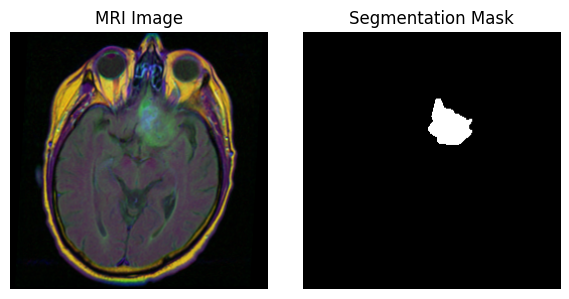

In [ ]:
to_pil = transforms.ToPILImage()

img, mask = train_dataset.__getitem__(10) #The pair (image, mask) is the same but whenever we call __getitem__ a random transformation is applied
print(f"Augmented image shape: {img.shape}")
print(f"Augmented mask shape: {mask.shape}")
print(f"Unique values in augmented mask: {torch.unique(mask)}")

img = to_pil(img)
mask = to_pil(mask)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # 1 row, 2 columns

axes[0].imshow(img, cmap='gray')   # or cmap=None if it's RGB
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
np_img = np.array(img)
print(np_img.shape)

(256, 256, 3)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2) #reduces channels (1024->512) and upscale image (16x16->32x32)
        self.dec4 = conv_block(1024, 512)                     #after torch.cat(d4, e4), channels are concatenated, thus channels=512+512=1024, so a conv block reduces it back to 512
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        #print(x.shape)
        e1 = self.enc1(x)
        #print(e1.shape)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        #print(e2.shape)
        e3 = self.enc3(F.max_pool2d(e2, 2))
        #print(e3.shape)
        e4 = self.enc4(F.max_pool2d(e3, 2))
        #print(e4.shape)
        b  = self.bottleneck(F.max_pool2d(e4, 2))
        #print(b.shape)

        d4 = self.up4(b)
        #print(d4.shape)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        #print(d4.shape)
        d3 = self.up3(d4)
        #print(d3.shape)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        #print(d3.shape)
        d2 = self.up2(d3)
        #print(d2.shape)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        #print(d2.shape)
        d1 = self.up1(d2)
        #print(d1.shape)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        #print(d1.shape)

        out = self.out_conv(d1)
        #print(out.shape)
        return torch.sigmoid(out)  # since output mask is binary

In [ ]:
model = UNet().to(device)
model

# Grid Search

In [ ]:
from itertools import product

# Define the U-Net specific hyperparameter grid
param_grid = {
    'learning_rate': [1e-3, 1e-4],  # Two options for LR
    'batch_size': [4, 16, 32],      # Three options for batch size
    'optimizer': ['Adam', 'SGD'],   # Two optimizer choices
    'criterion': ['BCE', 'combined_loss']
}

# Get all combinations of hyperparameters
# This will generate 2 * 2 * 2 = 8 total combinations
all_combinations = list(product(*param_grid.values()))

print(f"Total combinations to test: {len(all_combinations)}")
# Example output: [(0.001, 16, 'Adam'), (0.001, 16, 'SGD'), ...]
print("Combinations:\n ", all_combinations)

Total combinations to test: 24
Combinations:
  [(0.001, 4, 'Adam', 'BCE'), (0.001, 4, 'Adam', 'combined_loss'), (0.001, 4, 'SGD', 'BCE'), (0.001, 4, 'SGD', 'combined_loss'), (0.001, 16, 'Adam', 'BCE'), (0.001, 16, 'Adam', 'combined_loss'), (0.001, 16, 'SGD', 'BCE'), (0.001, 16, 'SGD', 'combined_loss'), (0.001, 32, 'Adam', 'BCE'), (0.001, 32, 'Adam', 'combined_loss'), (0.001, 32, 'SGD', 'BCE'), (0.001, 32, 'SGD', 'combined_loss'), (0.0001, 4, 'Adam', 'BCE'), (0.0001, 4, 'Adam', 'combined_loss'), (0.0001, 4, 'SGD', 'BCE'), (0.0001, 4, 'SGD', 'combined_loss'), (0.0001, 16, 'Adam', 'BCE'), (0.0001, 16, 'Adam', 'combined_loss'), (0.0001, 16, 'SGD', 'BCE'), (0.0001, 16, 'SGD', 'combined_loss'), (0.0001, 32, 'Adam', 'BCE'), (0.0001, 32, 'Adam', 'combined_loss'), (0.0001, 32, 'SGD', 'BCE'), (0.0001, 32, 'SGD', 'combined_loss')]


In [ ]:
min_val_loss_results = [0.0146, 0.3985, 0.0358, 0.4679, 0.0140, 0.4028, 0.0818, 0.5471, 0.0158, 0.4005, 0.1409, 0.6176, 0.0152, 0.3930, 0.1730, 0.6271, 0.0560, 0.4477, 0.4101, 0.7391, 0.0996, 0.5442, 0.4969, 0.8010]
results = []

for i, combination in enumerate(all_combinations):
    current_params = dict(zip(param_grid.keys(), combination))
    current_params['min_val_loss'] = min_val_loss_results[i]
    results.append(current_params)

# Summary of all runs (for heatmaps)
runs_df = pd.DataFrame(results)

# Detailed epoch data (for line plots)
#epochs_df = pd.DataFrame(epoch_data_list)

# Save to CSV files so the next steps can use them
runs_df.to_csv('grid_search_summary.csv', index=False)

/tmp/ipython-input-2453759045.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make room for suptitle


Faceted heatmap saved as 'faceted_heatmap.png'


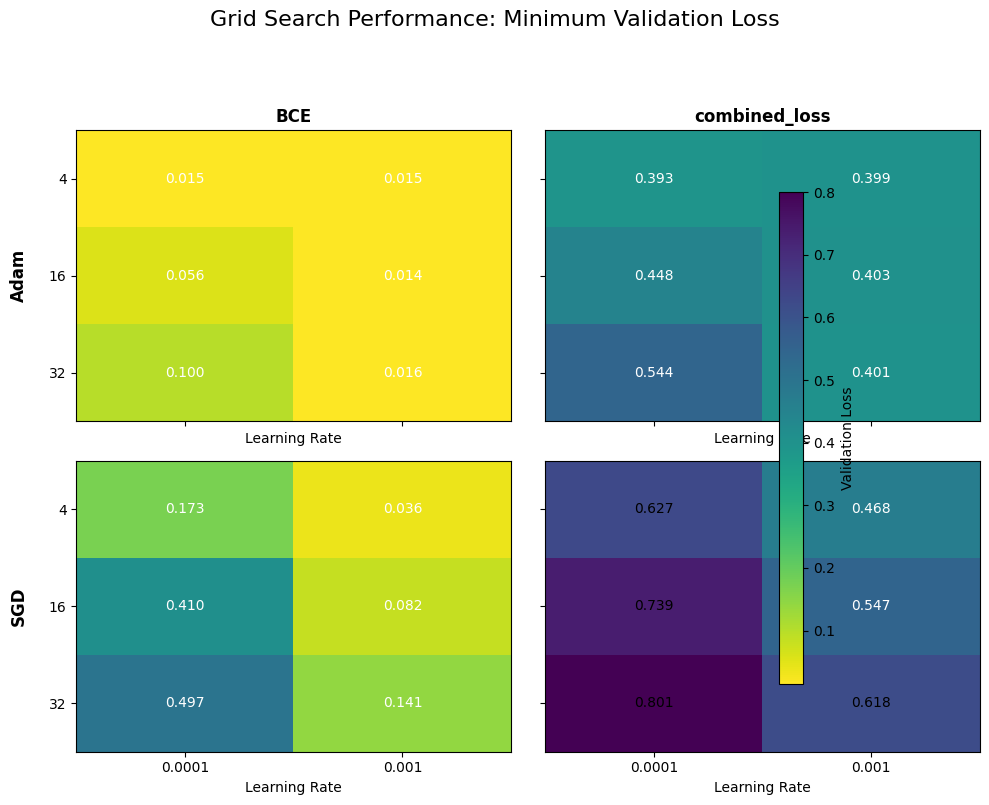

In [ ]:
# Load the summary data
runs_df = pd.read_csv('grid_search_summary.csv')

# Get unique values for faceting
optimizers = runs_df['optimizer'].unique()
losses = runs_df['criterion'].unique()
lrs = sorted(runs_df['learning_rate'].unique())
batch_sizes = sorted(runs_df['batch_size'].unique())

n_rows = len(optimizers)
n_cols = len(losses)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 5, n_rows * 4),
                         sharex=True, sharey=True,
                         squeeze=False) # Ensure axes is always 2D array

fig.suptitle('Grid Search Performance: Minimum Validation Loss', fontsize=16, y=1.03)

# Find global min/max for consistent color scaling
vmin = runs_df['min_val_loss'].min()
vmax = runs_df['min_val_loss'].max()

for i, opt in enumerate(optimizers):
    for j, loss_fn in enumerate(losses):
        ax = axes[i, j]

        # Set row/col titles
        if i == 0:
            ax.set_title(loss_fn, fontweight='bold')
        if j == 0:
            ax.set_ylabel(opt, fontweight='bold', fontsize=12, labelpad=15)

        # Filter data for this subplot
        subset = runs_df[(runs_df['optimizer'] == opt) & (runs_df['criterion'] == loss_fn)]

        if subset.empty:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            continue

        # Pivot data to create the 2D matrix for the heatmap
        try:
            pivot_table = subset.pivot(index='batch_size', columns='learning_rate', values='min_val_loss')
            # Reindex to ensure correct order
            pivot_table = pivot_table.reindex(index=batch_sizes, columns=lrs)

            # Draw the heatmap
            im = ax.imshow(pivot_table, cmap='viridis_r', vmin=vmin, vmax=vmax, aspect='auto')

            # Add text annotations for the values
            for r_idx, r_val in enumerate(pivot_table.index):
                for c_idx, c_val in enumerate(pivot_table.columns):
                    value = pivot_table.loc[r_val, c_val]
                    ax.text(c_idx, r_idx, f'{value:.3f}', ha='center', va='center', color='white' if value < (vmax * 0.7) else 'black')

        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {e}', ha='center', va='center', transform=ax.transAxes)

        # Set ticks and labels
        ax.set_xticks(np.arange(len(lrs)))
        ax.set_xticklabels(lrs)
        ax.set_yticks(np.arange(len(batch_sizes)))
        ax.set_yticklabels(batch_sizes)

        ax.set_xlabel('Learning Rate')

# Add a single shared colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label='Validation Loss')

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make room for suptitle
plt.savefig('faceted_heatmap.png')
print("Faceted heatmap saved as 'faceted_heatmap.png'")

In [ ]:
def dice_loss(pred, target, eps=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3)) #sum over height and width
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) #sum over height and width
    dice = (2. * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def combined_loss(pred, target, criterion):
    return 0.5 * criterion(pred, target) + 0.5 * dice_loss(pred, target)

In [ ]:
def train_and_validate(params, num_epochs):
  train_loss_list = []
  val_loss_list = []
  best_val_loss = float('inf')
  lr, batch_dim, optimizer_name, criterion_name = params

  #Early stopping
  patience = 5
  early_stopping = EarlyStopping(patience=patience, verbose=True)

  # Create loaders
  train_loader = DataLoader(train_dataset, batch_size=batch_dim, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_dim, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_dim, shuffle=False)

  model = UNet().to(device)

  criterion = nn.BCELoss()  # Binary Cross Entropy (for binary masks)

  #Select optimizer
  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr)
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr)

  for epoch in tqdm(range(num_epochs)):
    #TRAINING STAGE
      model.train()
      train_loss = 0.0

      for imgs, masks in train_loader:
          imgs, masks = imgs.to(device), masks.to(device)

          optimizer.zero_grad()
          outputs = model(imgs)

          #Select LOSS
          if criterion_name == 'BCE':
            loss = criterion(outputs, masks)
          elif criterion_name == 'combined_loss':
            loss = combined_loss(outputs, masks, criterion)

          loss.backward()
          optimizer.step()

          train_loss += loss.item() * imgs.size(0)

  #VALIDATION STAGE
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for imgs, masks in val_loader:
              imgs, masks = imgs.to(device), masks.to(device)
              outputs = model(imgs)

              #Select LOSS
              if criterion_name == 'BCE':
                loss = criterion(outputs, masks)
              elif criterion_name == 'combined_loss':
                loss = combined_loss(outputs, masks, criterion)

              val_loss += loss.item() * imgs.size(0)


      train_loss /= len(train_loader.dataset)
      val_loss /= len(val_loader.dataset)

      early_stopping(val_loss, model)

      if early_stopping.early_stop:
        print("Early Stopping!")
        break

      train_loss_list.append(round(train_loss, 4))
      val_loss_list.append(round(val_loss, 4))

      # Keep track of the best loss over epochs
      if val_loss < best_val_loss:
          best_val_loss = val_loss

  print("Training loss: ", train_loss_list)
  print("Validation loss: ", val_loss_list)

  return best_val_loss

#print(f"Epoch [{epoch+1}/{n_epochs}]  Train Loss: {train_loss:.4f}")
#print(f"Val Loss: {val_loss:.4f}")

In [ ]:
already_seen_combs = [
    (1e-3, 4, 'Adam', 'BCE'), (1e-3, 4, 'Adam', 'combined_loss'), (1e-3, 4, 'SGD', 'BCE'), (1e-3, 4, 'SGD', 'combined_loss'),
    (1e-3, 16, 'Adam', 'combined_loss'), (1e-3, 16, 'SGD', 'BCE'), (1e-3, 16, 'SGD', 'combined_loss'), #(1e-3, 16, 'Adam', 'BCE')
    (1e-3, 32, 'Adam', 'BCE'), (1e-3, 32, 'Adam', 'combined_loss'), (1e-3, 32, 'SGD', 'BCE'), (1e-3, 32, 'SGD', 'combined_loss'),
    (1e-4, 4, 'Adam', 'BCE'), (1e-4, 4, 'Adam', 'combined_loss'), (1e-4, 4, 'SGD', 'BCE'), (1e-4, 4, 'SGD', 'combined_loss'),
    (1e-4, 16, 'Adam', 'BCE'), (1e-4, 16, 'Adam', 'combined_loss'), (1e-4, 16, 'SGD', 'BCE'), (1e-4, 16, 'SGD', 'combined_loss'),
    (1e-4, 32, 'Adam', 'BCE'), (1e-4, 32, 'Adam', 'combined_loss'), (1e-4, 32, 'SGD', 'BCE'), (1e-4, 32, 'SGD', 'combined_loss')
]

In [ ]:
#EARLY STOP CLASS

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): function to use for printing messages.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
#EXECUTE GRID SEARCH

results = {}
best_score = float('inf')
best_params = None

# Iterate through all hyperparameter combinations
for i, combination in enumerate(all_combinations):
    if combination in already_seen_combs:
      continue
    # Map the combination values back to the parameter names
    # This is necessary because `itertools.product` only gives values
    current_params = dict(zip(param_grid.keys(), combination))

    print(f"\n--- Running Trial {i+1}/{len(all_combinations)} ---")
    print(f"Parameters: {current_params}")

    # Run the training and get the validation loss
    try:
        val_loss = train_and_validate(combination, num_epochs=30) # 10 epochs per trial

        # Store the results
        results[tuple(combination)] = val_loss

        print(f"Resulting Validation Loss: {val_loss:.4f}")

        # Check if this is the best result found so far
        if val_loss < best_score:
            best_score = val_loss
            best_params = current_params
            print(">>> NEW BEST MODEL FOUND! <<<")

    except Exception as e:
        print(f"Trial failed for {current_params}: {e}")
        results[tuple(combination)] = float('nan')

torch.save(model.state_dict(), "/content/drive/MyDrive/Projects/Brain Tumor Segmentation/Adam_16_03_BCE.pth")
# --- Final Results Summary ---
print("\n" + "="*50)
print("GRID SEARCH COMPLETE")
print(f"Best Parameters: {best_params}")
print(f"Best Validation Loss: {best_score:.4f}")
print("="*50)

In [ ]:
# Create loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

In [ ]:
criterion = nn.BCELoss()  # Binary Cross Entropy (for binary masks)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
#BACKUP
n_epochs = 30
train_loss_list = []
val_loss_list = []
patience = 5
earlystop = EarlyStopping(patience=patience, verbose=True)

for epoch in tqdm(range(n_epochs)):
  #TRAINING STAGE
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss(outputs, masks, criterion)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

#VALIDATION STAGE
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = combined_loss(outputs, masks, criterion)
            val_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    earlystop(val_loss, model)

    if earlystop.early_stop:
      print("Early Stopping!")
      break

    train_loss_list.append(round(train_loss, 4))
    val_loss_list.append(round(val_loss, 4))

    print(f"Epoch [{epoch+1}/{n_epochs}]  Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.635193).  Saving model ...
Epoch [1/30]  Train Loss: 0.6878
Val Loss: 0.6352
Validation loss decreased (0.635193 --> 0.587750).  Saving model ...
Epoch [2/30]  Train Loss: 0.6103
Val Loss: 0.5877
Validation loss decreased (0.587750 --> 0.554368).  Saving model ...
Epoch [3/30]  Train Loss: 0.5677
Val Loss: 0.5544
Validation loss decreased (0.554368 --> 0.529529).  Saving model ...
Epoch [4/30]  Train Loss: 0.5374
Val Loss: 0.5295
Validation loss decreased (0.529529 --> 0.503167).  Saving model ...
Epoch [5/30]  Train Loss: 0.5081
Val Loss: 0.5032
Validation loss decreased (0.503167 --> 0.471549).  Saving model ...
Epoch [6/30]  Train Loss: 0.4860
Val Loss: 0.4715
Validation loss decreased (0.471549 --> 0.466686).  Saving model ...
Epoch [7/30]  Train Loss: 0.4624
Val Loss: 0.4667
Validation loss decreased (0.466686 --> 0.461871).  Saving model ...
Epoch [8/30]  Train Loss: 0.4433
Val Loss: 0.4619
Validation loss decreased (0.461871 --> 0.429204).  S

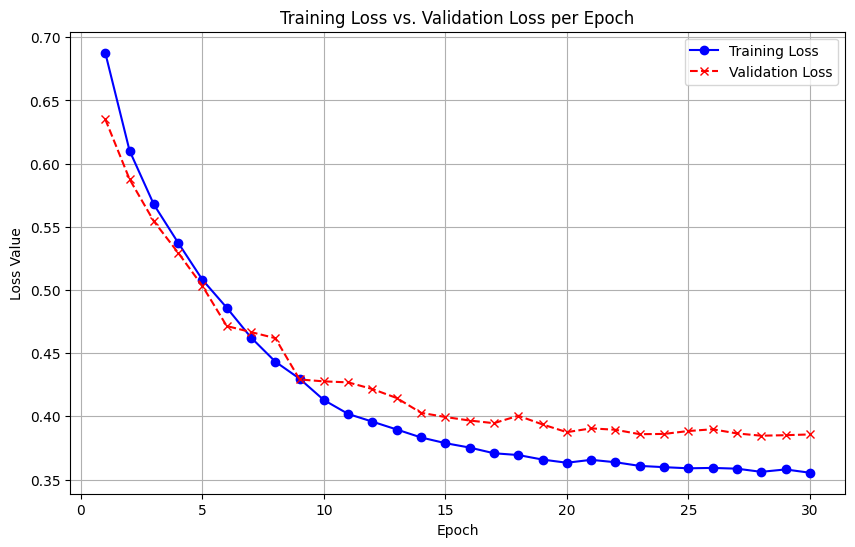

In [ ]:
# --- 2. Matplotlib Plotting Code ---
plt.figure(figsize=(10, 6)) # Create a new figure with a specified size

# Plot the training loss
plt.plot(range(1, n_epochs+1), train_loss_list, label='Training Loss', marker='o', linestyle='-', color='blue')

# Plot the validation loss
plt.plot(range(1, n_epochs+1), val_loss_list, label='Validation Loss', marker='x', linestyle='--', color='red')

# Add a title and labels
plt.title('Training Loss vs. Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

# Add a legend to distinguish the two lines
plt.legend()

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
train_loss_base_UNet = [0.0358, 0.0246, 0.0189, 0.0167, 0.0142, 0.0124, 0.0108, 0.0098, 0.0098, 0.0089]
val_loss_base_UNet = [0.0391, 0.0347, 0.0363, 0.0241, 0.0215, 0.0233, 0.0186, 0.0213, 0.0185, 0.0177]
train_loss_UNet_16BATCH = [0.3695, 0.3636, 0.3621, 0.3609, 0.3587, 0.3573, 0.3559, 0.3564, 0.3551, 0.3547]
val_loss_UNet_16BATCH = [0.3948, 0.3886, 0.3872, 0.3922, 0.3869, 0.3908, 0.3843, 0.3878, 0.3867, 0.3912]

In [ ]:
print(train_loss_list)
print(val_loss_list)
#DICE SCORE 16BATCH, LR=1E03

[0.5275, 0.4805, 0.4495, 0.4385, 0.4244, 0.4246, 0.4195, 0.42, 0.4123, 0.4096, 0.408, 0.4052, 0.4068, 0.4051, 0.403, 0.4015, 0.402, 0.4002]
[0.5043, 0.4748, 0.4393, 0.4333, 0.4359, 0.4104, 0.4204, 0.4101, 0.4325, 0.4131, 0.4037, 0.4167, 0.4312, 0.3993, 0.4065, 0.4349, 0.4018, 0.4078]


In [ ]:
#ONLY IF YOU WANT TO SAVE THE TRAINING WEIGHTS
#torch.save(model.state_dict(), "/content/drive/MyDrive/Projects/Brain Tumor Segmentation/16_Adam1e4_combined.pth")
#model.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Brain Tumor Segmentation/unet_weights.pth"))
model.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Brain Tumor Segmentation/16_Adam1e4_combined.pth"))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
all_imgs = []
all_preds = []
all_gts = [] #ground truths

model.eval()

with torch.no_grad():
  for imgs, masks in tqdm(test_loader):
    imgs, masks = imgs.to(device), masks.to(device)

    outputs = model(imgs)

    loss = combined_loss(outputs, masks, criterion)
    test_loss += loss.item()

    all_imgs.append(imgs.cpu())
    all_preds.append(outputs.cpu())
    all_gts.append(masks.cpu())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/47 [00:00<?, ?it/s]

Test Loss: 0.3787


# Results

Configuration:

*   base UNet, batch size: 4, epochs: 10, loss: BCE, DICE on test set: 0.79
*   base UNet, batch size: 16, epochs: 10, loss: DICE, DICE on test set: 0.81
*   base UNet, batch size: 16, epochs: 30, loss: DICE, DICE on test set:
*   base UNet, batch size: 16, epochs: 30, loss: BCE + DICE, Adam 1e-4, DICE on test set: 0.831



In [ ]:
preds = torch.cat(all_preds) #concat all preds
gts   = torch.cat(all_gts)
imgs = torch.cat(all_imgs)

binary_preds = (preds > 0.5).float() #convert to binary masks

In [ ]:
def compute_scores(pred, target, eps=1e-6):
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (inter + eps)/(union + eps), (2 * inter + eps) / (union + eps)

In [ ]:
#print(binary_preds == gts)
accuracy = (binary_preds == gts).float().mean().item()
iou, dice = compute_scores(binary_preds, gts)

print("Dice coefficient score: ", dice)
print("IoU: ", iou)
print("Accuracy: ", accuracy)

Dice coefficient score:  tensor(0.8308)
IoU:  tensor(0.4154)
Accuracy:  0.9969557523727417


In [ ]:
imgs = [to_pil(img) for img in imgs]
gts = [to_pil(gt) for gt in gts]
preds_to_plot = [to_pil(pred) for pred in binary_preds]

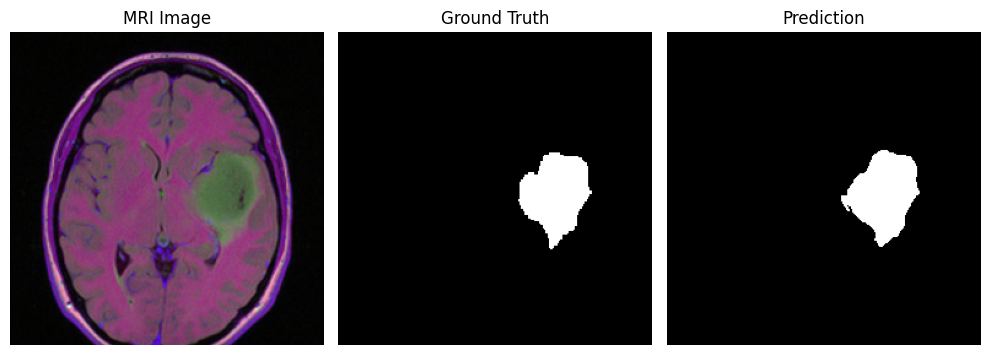

In [ ]:
interval = len(imgs)

idx = rd.randint(0, interval-1)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(imgs[idx], cmap=None)   # or cmap=None if it's RGB
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(gts[idx], cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis("off")

axes[2].imshow(preds_to_plot[idx], cmap='gray')
axes[2].set_title("Prediction")
axes[2].axis("off")

plt.tight_layout()
plt.show()